In [2]:
import h5py, os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Ellipse
from skymapper import Map, projection

from msfm.utils import files, scales

In [3]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

# 246pt in inches (for the Phys Rev template)
half_linewidth = 3.41
# 510pt in inches (figure* environment in the Phys Rev template)
full_linewidth = 7.06

In [4]:
conf = "/Users/arne/git/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml"
conf = files.load_config(conf)

n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)

data_vec_pix, patches_pix_dict, _, _ = files.load_pixel_file(conf)
patches = patches_pix_dict["metacal"][0]

24-10-18 08:54:41     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


In [5]:
def add_black_rim(ax, color="black", linewidth=0.5):
    """Add a black rim around the Mollweide projection plot."""
    # the parameters for the ellipse were found by trial and error
    ellipse = Ellipse(xy=(0, 0), width=4, height=2, edgecolor=color, facecolor="none", linewidth=linewidth)
    ax.add_patch(ellipse)

# rotated footprint

In [6]:
mask_dir = f"/Users/arne/data/DESY3/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits.gz"

data, header = fits.getdata(mask_dir, header = True)
mask_inds = data["HPIX"]

ud_threshold = 0.5

original_mask = np.zeros(hp.nside2npix(4096))
original_mask[mask_inds] = 1

mask = hp.ud_grade(original_mask, nside_out=n_side)
mask[mask < ud_threshold] = 0
mask[mask >= ud_threshold] = 1
mask = mask.astype(bool)

rotator = hp.Rotator(rot=(0, 0.125, -1.22), eulertype="Y", deg=False)
rot_mask = rotator.rotate_map_pixel(original_mask)
rot_mask = hp.ud_grade(rot_mask, nside_out=n_side)
rot_mask[rot_mask < ud_threshold] = 0
rot_mask[rot_mask >= ud_threshold] = 1
rot_mask = rot_mask.astype(bool)

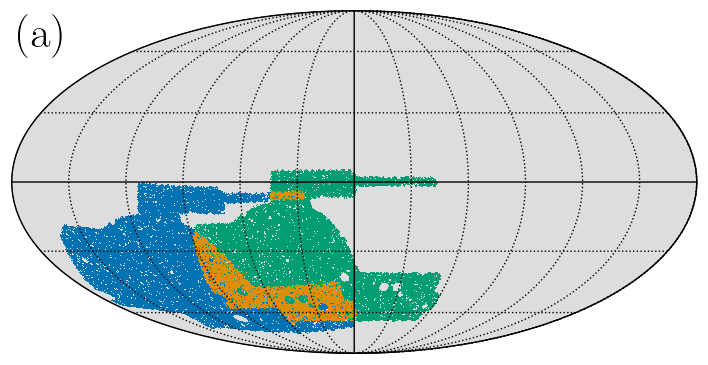

In [7]:
combined_mask = np.full(n_pix, hp.UNSEEN)
combined_mask[~mask & rot_mask] = 0.0
combined_mask[mask & rot_mask] = 0.5
combined_mask[mask & ~rot_mask] = 1.0

# color map
colors = sns.color_palette("colorblind", 3)
norm_values = np.linspace(0, 1, 3)
color_list = [(norm_values[i], colors[i]) for i in range(len(colors))]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', color_list)

# plt.figure(figsize=(half_linewidth, 0.5*half_linewidth))
plt.figure(figsize=(full_linewidth, 0.5*full_linewidth))
hp.mollview(combined_mask, title="", cmap=custom_cmap, cbar=False, xsize=3000, badcolor="#dddddd", nest=False, sub=(1, 1, 1))

hp.graticule()
ax = plt.gca()
add_black_rim(ax)

ax.text(0.01, 0.99, '(a)', transform=ax.transAxes, fontsize=32, verticalalignment='top', weight='bold')

plt.savefig("plots/mask_rotation.png", bbox_inches="tight", dpi=300)
plt.savefig("plots/mask_rotation.pdf", bbox_inches="tight")

# patches

In [8]:
# color map
colors = sns.color_palette("colorblind", len(patches))
norm_values = np.linspace(0, 1, len(colors)+1)
color_list = [(norm_values[i], colors[i]) for i in range(len(colors))]
# add black for the padding
color_list.append((1, (0, 0, 0)))
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', color_list)

# nested ordering
patches_map = np.full(n_pix, hp.UNSEEN, dtype=np.float32)

# patches
for i, patch in enumerate(patches):
    patches_map[hp.ring2nest(n_side, patch)] = norm_values[i]

# padding
patches_map[data_vec_pix] = norm_values[-1]
patches_map[hp.ring2nest(n_side, patches[0])] = norm_values[0]

### healpy

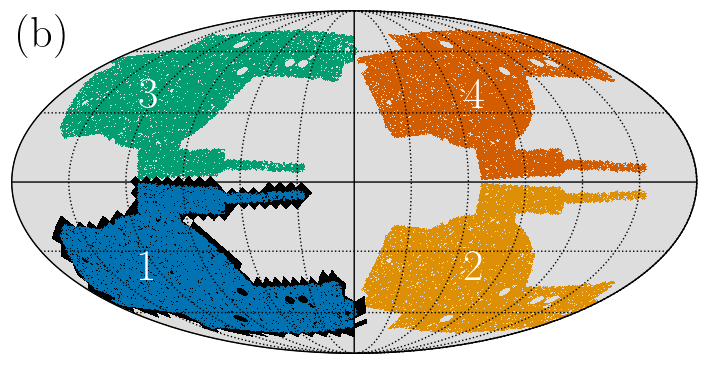

In [9]:
# plt.figure(figsize=(half_linewidth, 0.5*half_linewidth))
plt.figure(figsize=(full_linewidth, 0.5*full_linewidth))

hp.mollview(patches_map, title="", cmap=custom_cmap, cbar=False, xsize=3000, badcolor="#dddddd", nest=True, sub=(1, 1, 1))

hp.graticule()
ax = plt.gca()
add_black_rim(ax)

alignment = {"horizontalalignment": "center", "verticalalignment": "center"}
ax.text(-1.2, -0.5, "1", fontsize=32, color="white", fontweight='bold', **alignment)
ax.text(-1.2, 0.5, "3", fontsize=32, color="white", fontweight='bold', **alignment)
ax.text(0.7, -0.5, "2", fontsize=32, color="white", fontweight='bold', **alignment)
ax.text(0.7, 0.5, "4", fontsize=32, color="white", fontweight='bold', **alignment)

# ax.text(-1.2, -0.5, "1", fontsize=32, color="white", fontweight='bold')
# ax.text(-1.2, 0.5, "3", fontsize=32, color="white", fontweight='bold')
# ax.text(0.7, -0.5, "2", fontsize=32, color="white", fontweight='bold')
# ax.text(0.7, 0.5, "4", fontsize=32, color="white", fontweight='bold')

ax.text(0.01, 0.99, '(b)', transform=ax.transAxes, fontsize=32, verticalalignment='top', weight='bold')

plt.savefig("plots/patches.png", bbox_inches="tight", dpi=300)
plt.savefig("plots/patches.pdf", bbox_inches="tight")

### hard vs. soft cut

In [10]:
data_vec_pix, patches_pix_dict, _, _ = files.load_pixel_file(conf)
mask = hp.ring2nest(n_side, patches_pix_dict["metacal"][0][0])
anti_mask = np.setdiff1d(np.arange(n_pix), mask)

l_max = 509
theta_fwhm = 34.1
noise_sigma = 1.5098e-01

# in degrees
x_deg = 10
y_deg = x_deg

# in pixels
x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

# for the rotated DES footprint
rot = (90, -30, 0)
# rot = (90, -32, 0)

24-10-18 08:55:49     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


In [11]:
mask_map = np.zeros(n_pix)
mask_map[mask] = 1
mask_map, mask_map_alms = scales.map_to_smoothed_map(mask_map.copy(), n_side, nest=True, hard_cut=True)

hard_mask, hard_mask_alms = scales.map_to_smoothed_map(mask_map.copy(), n_side, l_max=l_max, nest=True, hard_cut=True)
soft_mask, soft_mask_alms = scales.map_to_smoothed_map(mask_map.copy(), n_side, theta_fwhm=theta_fwhm, nest=True, hard_cut=False)

hard_mask[anti_mask] = hp.UNSEEN
soft_mask[anti_mask] = hp.UNSEEN

gnom_hard = hp.gnomview(
    hard_mask, nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True
)
gnom_soft = hp.gnomview(
    soft_mask, nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True
)
gnom_mask = hp.gnomview(
    mask_map, nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True
)

24-10-18 08:55:57     files.py WAR   Loading the default config from /Users/arne/git/multiprobe-simulation-forward-model/configs/config.yaml 
24-10-18 08:55:57     files.py WAR   Loading the default config from /Users/arne/git/multiprobe-simulation-forward-model/configs/config.yaml 
24-10-18 08:55:57     files.py WAR   Loading the default config from /Users/arne/git/multiprobe-simulation-forward-model/configs/config.yaml 


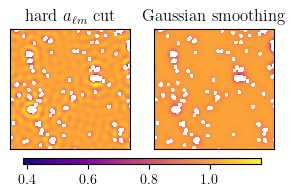

In [17]:
fig, ax = plt.subplots(figsize=(half_linewidth, 0.66*half_linewidth), ncols=2)
# fig, ax = plt.subplots(figsize=(10, 0.66*10), ncols=2)

# cmap = "inferno"
cmap = "plasma"
# cmap = "mako"
# cmap = "viridis"
# cmap = sns.color_palette("rocket", as_cmap=True)
vmin = min(gnom_hard.min(), gnom_soft.min())
vmax = max(gnom_hard.max(), gnom_soft.max())

# im_0 = ax[0].imshow(gnom_hard)
# im_1 = ax[1].imshow(gnom_soft)
im_0 = ax[0].imshow(gnom_hard, cmap=cmap, vmin=vmin, vmax=vmax)
im_1 = ax[1].imshow(gnom_soft, cmap=cmap, vmin=vmin, vmax=vmax)

ax[0].set(title=r"hard $a_{\ell m}$ cut")
ax[1].set(title=r"Gaussian smoothing")

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_aspect("equal")

# ax[0].text(0.03, 0.97, '(a)', transform=ax[0].transAxes, fontsize=16, verticalalignment='top', weight='bold')
# ax[1].text(0.03, 0.97, '(b)', transform=ax[1].transAxes, fontsize=16, verticalalignment='top', weight='bold')

fig.colorbar(im_1, ax=ax, orientation="horizontal", shrink=0.9, aspect=40, pad=0.05)
plt.savefig("plots/masking_artifacts.pdf", bbox_inches="tight")

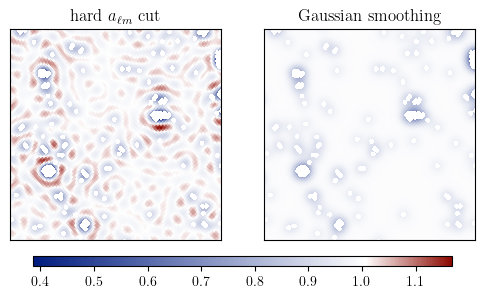

In [183]:
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(figsize=(half_linewidth, 0.66*half_linewidth), ncols=2)

vmin = min(gnom_hard.min(), gnom_soft.min())
vmax = max(gnom_hard.max(), gnom_soft.max())

p = (1.0 - vmin) / (vmax - vmin)
p = max(0.0, min(1.0, p))

cmap = sns.color_palette("dark")
colors = [
    (0.0, cmap[0]),    # At vmin
    (p+0.01, 'white'),     # At data value 1.0
    (1.0, cmap[3])      # At vmax
]
# colors = [
#     (0.0, cmap[0]),    # At vmin
#     (p, 'white'),     # At data value 1.0
#     (1.0, cmap[3])      # At vmax
# ]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

im_0 = ax[0].imshow(gnom_hard, cmap=cmap, vmin=vmin, vmax=vmax)
im_1 = ax[1].imshow(gnom_soft, cmap=cmap, vmin=vmin, vmax=vmax)

ax[0].set(title=r"hard $a_{\ell m}$ cut")
ax[1].set(title=r"Gaussian smoothing")
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_aspect("equal")

fig.colorbar(im_1, ax=ax, orientation="horizontal", shrink=0.9, aspect=40, pad=0.05)
plt.savefig("plots/masking_artifacts.pdf", bbox_inches="tight")

# deprecated

### skymapper

In [18]:
# moll = Map(projection.Mollweide())
# moll.healpix(
#     patches_map_masked,
#     cmap="viridis",
#     nest=True,
#     color_percentiles=[0, 100],
#     vmin=patches_map_masked.min(),
#     vmax=patches_map_masked.max(),
# )
# # moll.healpix(patches_map_masked, cmap="viridis", nest=False, color_percentiles=None)
# # moll.healpix(patches_map_masked, cmap=custom_cmap, nest=False, color_percentiles=[0,100])
# # moll.healpix(patches_map, cmap=custom_cmap, nest=False)

# # moll.fig.set_size_inches((half_linewidth, 0.5*half_linewidth))
# moll.fig.set_size_inches((20, 10))
# # moll.fig.savefig("plots/placeholder_patches_1.png", bbox_inches="tight", dpi=600)

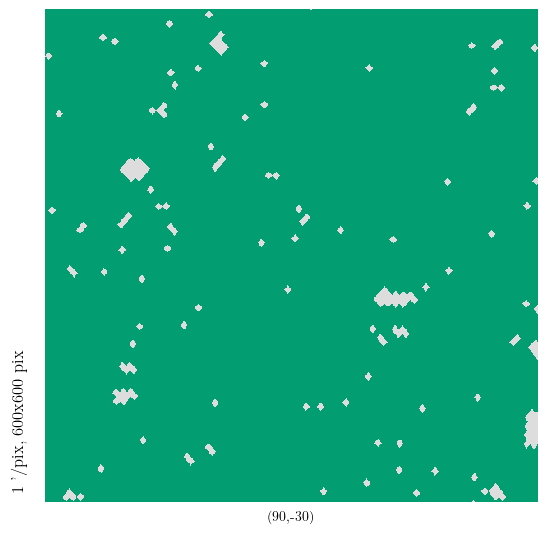

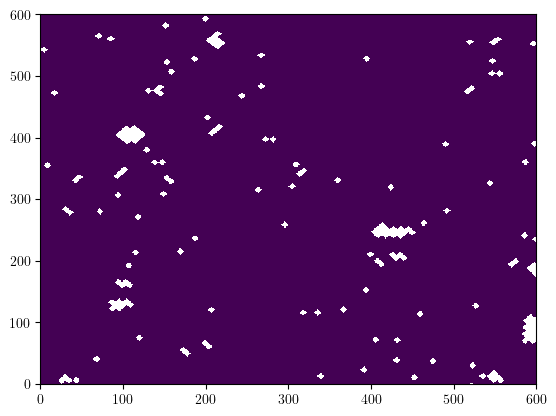

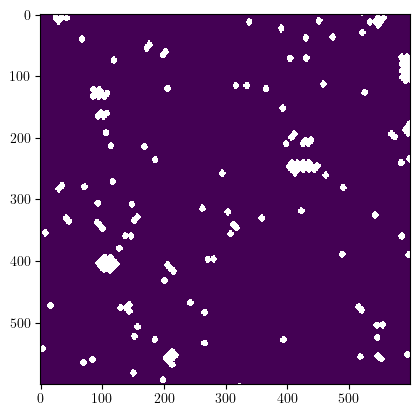

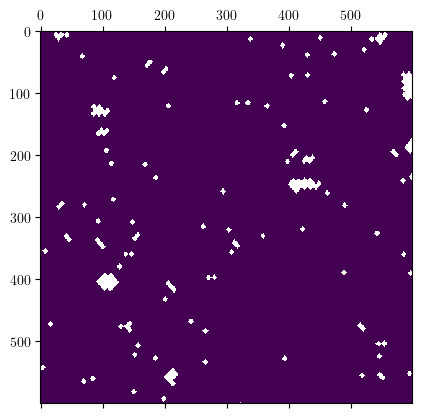

In [17]:
# in degrees
x_deg = 10
y_deg = x_deg

# in pixels
x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

patch_map = np.full(n_pix, hp.UNSEEN, dtype=np.float32)
patch_map[hp.ring2nest(n_side, patches[0])] = 1

gnom = hp.gnomview(
    # patches_map, 
    patch_map,
    title="", 
    cmap=custom_cmap, 
    cbar=False, 
    badcolor="#dddddd", 
    nest=True, 
    rot=(90, -30, 0), 
    xsize=x_pix, 
    ysize=y_pix,
    reso=reso,
    return_projected_map=True,
)
plt.show()

gnom = np.ma.masked_where(gnom==hp.UNSEEN, gnom)

plt.pcolormesh(gnom)
plt.show()

plt.imshow(gnom)
plt.show()

plt.matshow(gnom)
plt.show()

### original orientation

In [21]:
# data given by Dominik
data_dir = '/Users/arne/data/DESY3/DES_Y3KP_NGSF/'

# consider all tomographic bins
tomo = 0

# J2000 angles in degrees
alpha = h5py.File(os.path.join(data_dir, f'ALPHAWIN_J2000_tomo={tomo}.h5'))['ALPHAWIN_J2000'][:]
delta = h5py.File(os.path.join(data_dir, f'DELTAWIN_J2000_tomo={tomo}.h5'))['DELTAWIN_J2000'][:]

# angles like in healpy in radian
theta = -np.deg2rad(delta) + np.pi/2
phi = np.deg2rad(alpha)

# derived pixel ids, shape (num_galaxies,)
pix = hp.ang2pix(nside=n_side, theta=theta, phi=phi)

# vector positions of the galaxies, shape (num_galaxies, 3)
vec = hp.ang2vec(theta=theta, phi=phi)

### rotated

In [22]:
def get_rot_x(ang):
    return np.array([[1.0, 0.0,         0.0],
                     [0.0, np.cos(ang), -np.sin(ang)],
                     [0.0, np.sin(ang), np.cos(ang)]]).T # Inverse because of healpy

def get_rot_y(ang):
    return np.array([[np.cos(ang),  0.0, np.sin(ang)],
                     [0.0,          1.0, 0.0],
                     [-np.sin(ang), 0.0, np.cos(ang)]]).T # Inverse because of healpy

def get_rot_z(ang):
    return np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]]).T # Inverse because of healpy

In [23]:
y_rot = get_rot_y(-0.125)
# y_rot.shape = (3,3), rot_vec.shape = (n_galaxies, 3)
rot_vec = np.dot(y_rot, vec.T)

z_rot = get_rot_z(-1.22)
# z_rot.shape = (3,3), rot_vec.shape = (3, n_galaxies)
rot_vec = np.dot(z_rot, rot_vec)

rot_pix = hp.vec2pix(n_side, rot_vec[0], rot_vec[1], rot_vec[2])

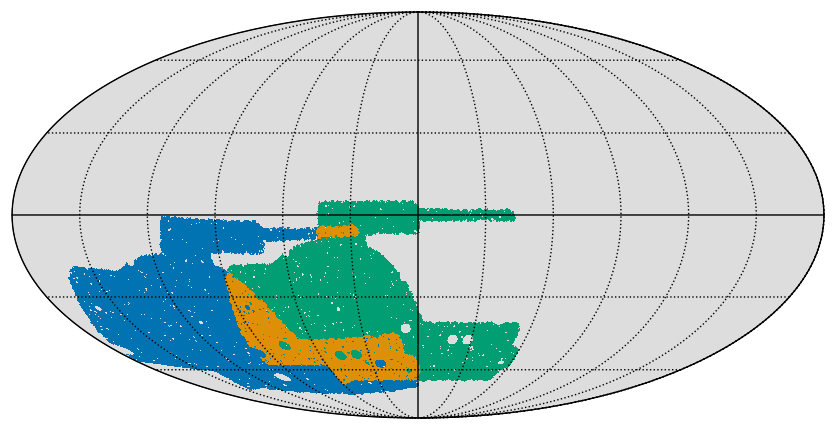

In [24]:
combined_mask = np.full(n_pix, hp.UNSEEN)
combined_mask[pix] = 1.0
combined_mask[rot_pix] = 0.0
combined_mask[np.intersect1d(pix, rot_pix)] = 0.5

# color map
colors = sns.color_palette("colorblind", 3)
norm_values = np.linspace(0, 1, 3)
color_list = [(norm_values[i], colors[i]) for i in range(len(colors))]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', color_list)

hp.mollview(combined_mask, title="", cmap=custom_cmap, cbar=False, xsize=3000, badcolor="#dddddd", nest=False)

hp.graticule()
ax = plt.gca()
add_black_rim(ax)

plt.savefig("plots/mask_rotation.png", bbox_inches="tight", dpi=300)

# combined

In [25]:
# # color map
# colors = sns.color_palette("colorblind", len(patches_pix_dict["maglim"]))
# norm_values = np.linspace(0, 1, len(colors)+1)
# color_list = [(norm_values[i], colors[i]) for i in range(len(colors))]
# # add black for the padding
# color_list.append((1, (0, 0, 0)))
# custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', color_list)


# plt.figure(figsize=(half_linewidth, 0.5*half_linewidth))

# hp.mollview(combined_mask, title="", cmap=custom_cmap, cbar=False, xsize=3000, badcolor="#dddddd", nest=False)
# hp.mollview(patches_map, title="", cmap=custom_cmap, cbar=False, xsize=3000, badcolor="#00000000", nest=True, reuse_axes=True)
# # hp.mollview(patches_map, title="", cbar=False, xsize=5000, badcolor="#dddddd")

# #00000000
# #dddddd

# hp.graticule()
# ax = plt.gca()
# add_black_rim(ax)

# ax.text(-1.2, -0.5, "1", fontsize=32, color="white", fontweight='bold')
# ax.text(-1.2, 0.5, "3", fontsize=32, color="white", fontweight='bold')
# ax.text(0.7, -0.5, "2", fontsize=32, color="white", fontweight='bold')
# ax.text(0.7, 0.5, "4", fontsize=32, color="white", fontweight='bold')

# combined_mask = np.full(n_pix, hp.UNSEEN)
# combined_mask[pix] = 1.0


# # plt.savefig("plots/placeholder_patches.png", bbox_inches="tight", dpi=300)